In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import os, sys
import numpy as np
from pathlib import Path
import pickle
import matplotlib as mpl
import time
import xarray as xr
from pathlib import Path

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

from load_ARSENL_data import load_INPHAMIS_data, set_binwidth, data_dir, fname, picklename

mpl.rcParams.update({"figure.facecolor": "white"})

# Plot fits for simulated results for paper

In [5]:
home = str(Path.home())

load_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss'

fname_dead_fit = r'\eval_loss_dtimeTrue_Rho1.0E+06-1.0E+10_order5-21_shots1.00E+06_best_fit.csv'
fname_pois_fit = r'\eval_loss_dtimeFalse_Rho1.0E+06-1.0E+10_order5-21_shots1.00E+06_best_fit.csv'

# fname_ttag = r'\fit_figures\eval_loss_dtimeTrue_Rho1000000.0-10000000000.0_order5-21_ref_shots1.00E+07_lsr_shots1.00E+05_use_final_True_best_fit.pkl'

df_dead_fit = pd.read_csv(load_dir + fname_dead_fit)
df_pois_fit = pd.read_csv(load_dir + fname_pois_fit)

# infile_ttag = open(load_dir + fname_ttag, 'rb')
# load_ttag = pickle.load(infile_ttag)

rho_lst = []
rho_name_lst = []
for column in df_dead_fit:
    if column[:3] == 'Rho':    
        rho_lst.append(float(column[3:]))
        rho_name_lst.append(column)
print('rho values investigated: {}'.format(rho_lst))

rho values investigated: [100000000.0, 10000000000.0, 1200000000.0, 13000000.0, 150000000.0, 1700000000.0, 18000000.0, 210000000.0, 25000000.0, 2500000000.0, 300000000.0, 3500000000.0, 36000000.0, 420000000.0, 5000000000.0, 51000000.0, 600000000.0, 7000000000.0, 73000000.0, 850000000.0]


In [50]:
idx = 2

t_fine = df_pois_fit['time vector'].to_numpy()
dead_fit = df_dead_fit[rho_name_lst[idx]]
pois_fit = df_pois_fit[rho_name_lst[idx]]

In [51]:
# Import generated sim data
# Make sure file matches the fits you've produced already

# Constants
c = 299792458  # [m/s] Speed of light

# Parameters
create_csv = False  # Set TRUE to generate a .csv from .ARSENL data
load_data = True  # Set TRUE to load data into a DataFrame and serialize into a pickle object
load_netcdf = True  # Set TRUE if loading from netcdf file ('*.ARSENL.nc'). Set FALSE if loading from *.ARSENL file.

dt = 25e-12  # [s] Resolution
deadtime = 25e-9  # [s] Deadtime interval (25ns for sim, 29.1ns for SPCM)
t_min = t_fine[0]
t_max = t_fine[-1]

# Load simulated data
home = str(Path.home())
data_dir = home + r'\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\Data\Simulated'
fname = r'\sim_amp1.2E+09_nshot1.0E+06.nc'

ds = xr.open_dataset(data_dir + fname)

cnts = ds.time_tag
flight_time = cnts * dt  # [s]
# Exclude specified t.o.f. bins
flight_time = flight_time[np.where((flight_time >= t_min) & (flight_time < t_max))]

true_cnts = ds.true_time_tag
true_flight_time = true_cnts * dt
true_flight_time = true_flight_time[np.where((true_flight_time>=t_min) & (true_flight_time<t_max))]

n_shots = len(ds.sync_index)
    
    
# Calculate Active Fraction value
deadtime_n_bins = np.floor(deadtime / dt).astype(int)
active_ratio_hst = n_shots * np.ones(len(t_fine)-1)

for i in range(len(flight_time)):
    det_time = flight_time[i].item()

    # Only include detections that fall within fitting window
    if det_time >= (t_min-deadtime) and det_time <= t_max:
        det_bin_idx = np.argmin(abs(det_time - t_fine))  # Bin that detection falls into
        final_dead_bin = det_bin_idx + deadtime_n_bins  # Final bin index that deadtime occupies

        # Currently a crutch that assumes "dead" time >> potwindow. Will need to include "wrap around" to be more accurate
        # If final dead bin surpasses fit window, set it to the window upper bin
        if final_dead_bin > len(active_ratio_hst):
            final_dead_bin = len(active_ratio_hst)
        # If initial dead bin (detection bin) precedes fit window, set it to the window lower bin
        if det_time < t_min:
            det_bin_idx = 0
        active_ratio_hst[det_bin_idx:final_dead_bin+1] -= 1  # Remove "dead" region in active ratio
        
active_ratio_hst /= n_shots
AF = np.mean(active_ratio_hst)

In [52]:
t_fine = np.arange(t_min, t_max, dt)

sig = ds.laser_pulse_width.to_numpy()
mu = ds.target_time.to_numpy()
A = ds.target_amplitude.to_numpy()
b = ds.background.to_numpy()

truth = A*np.exp(-(t_fine-mu)**2/2/sig**2)+b

Histogram plot time elapsed: 0.212 sec


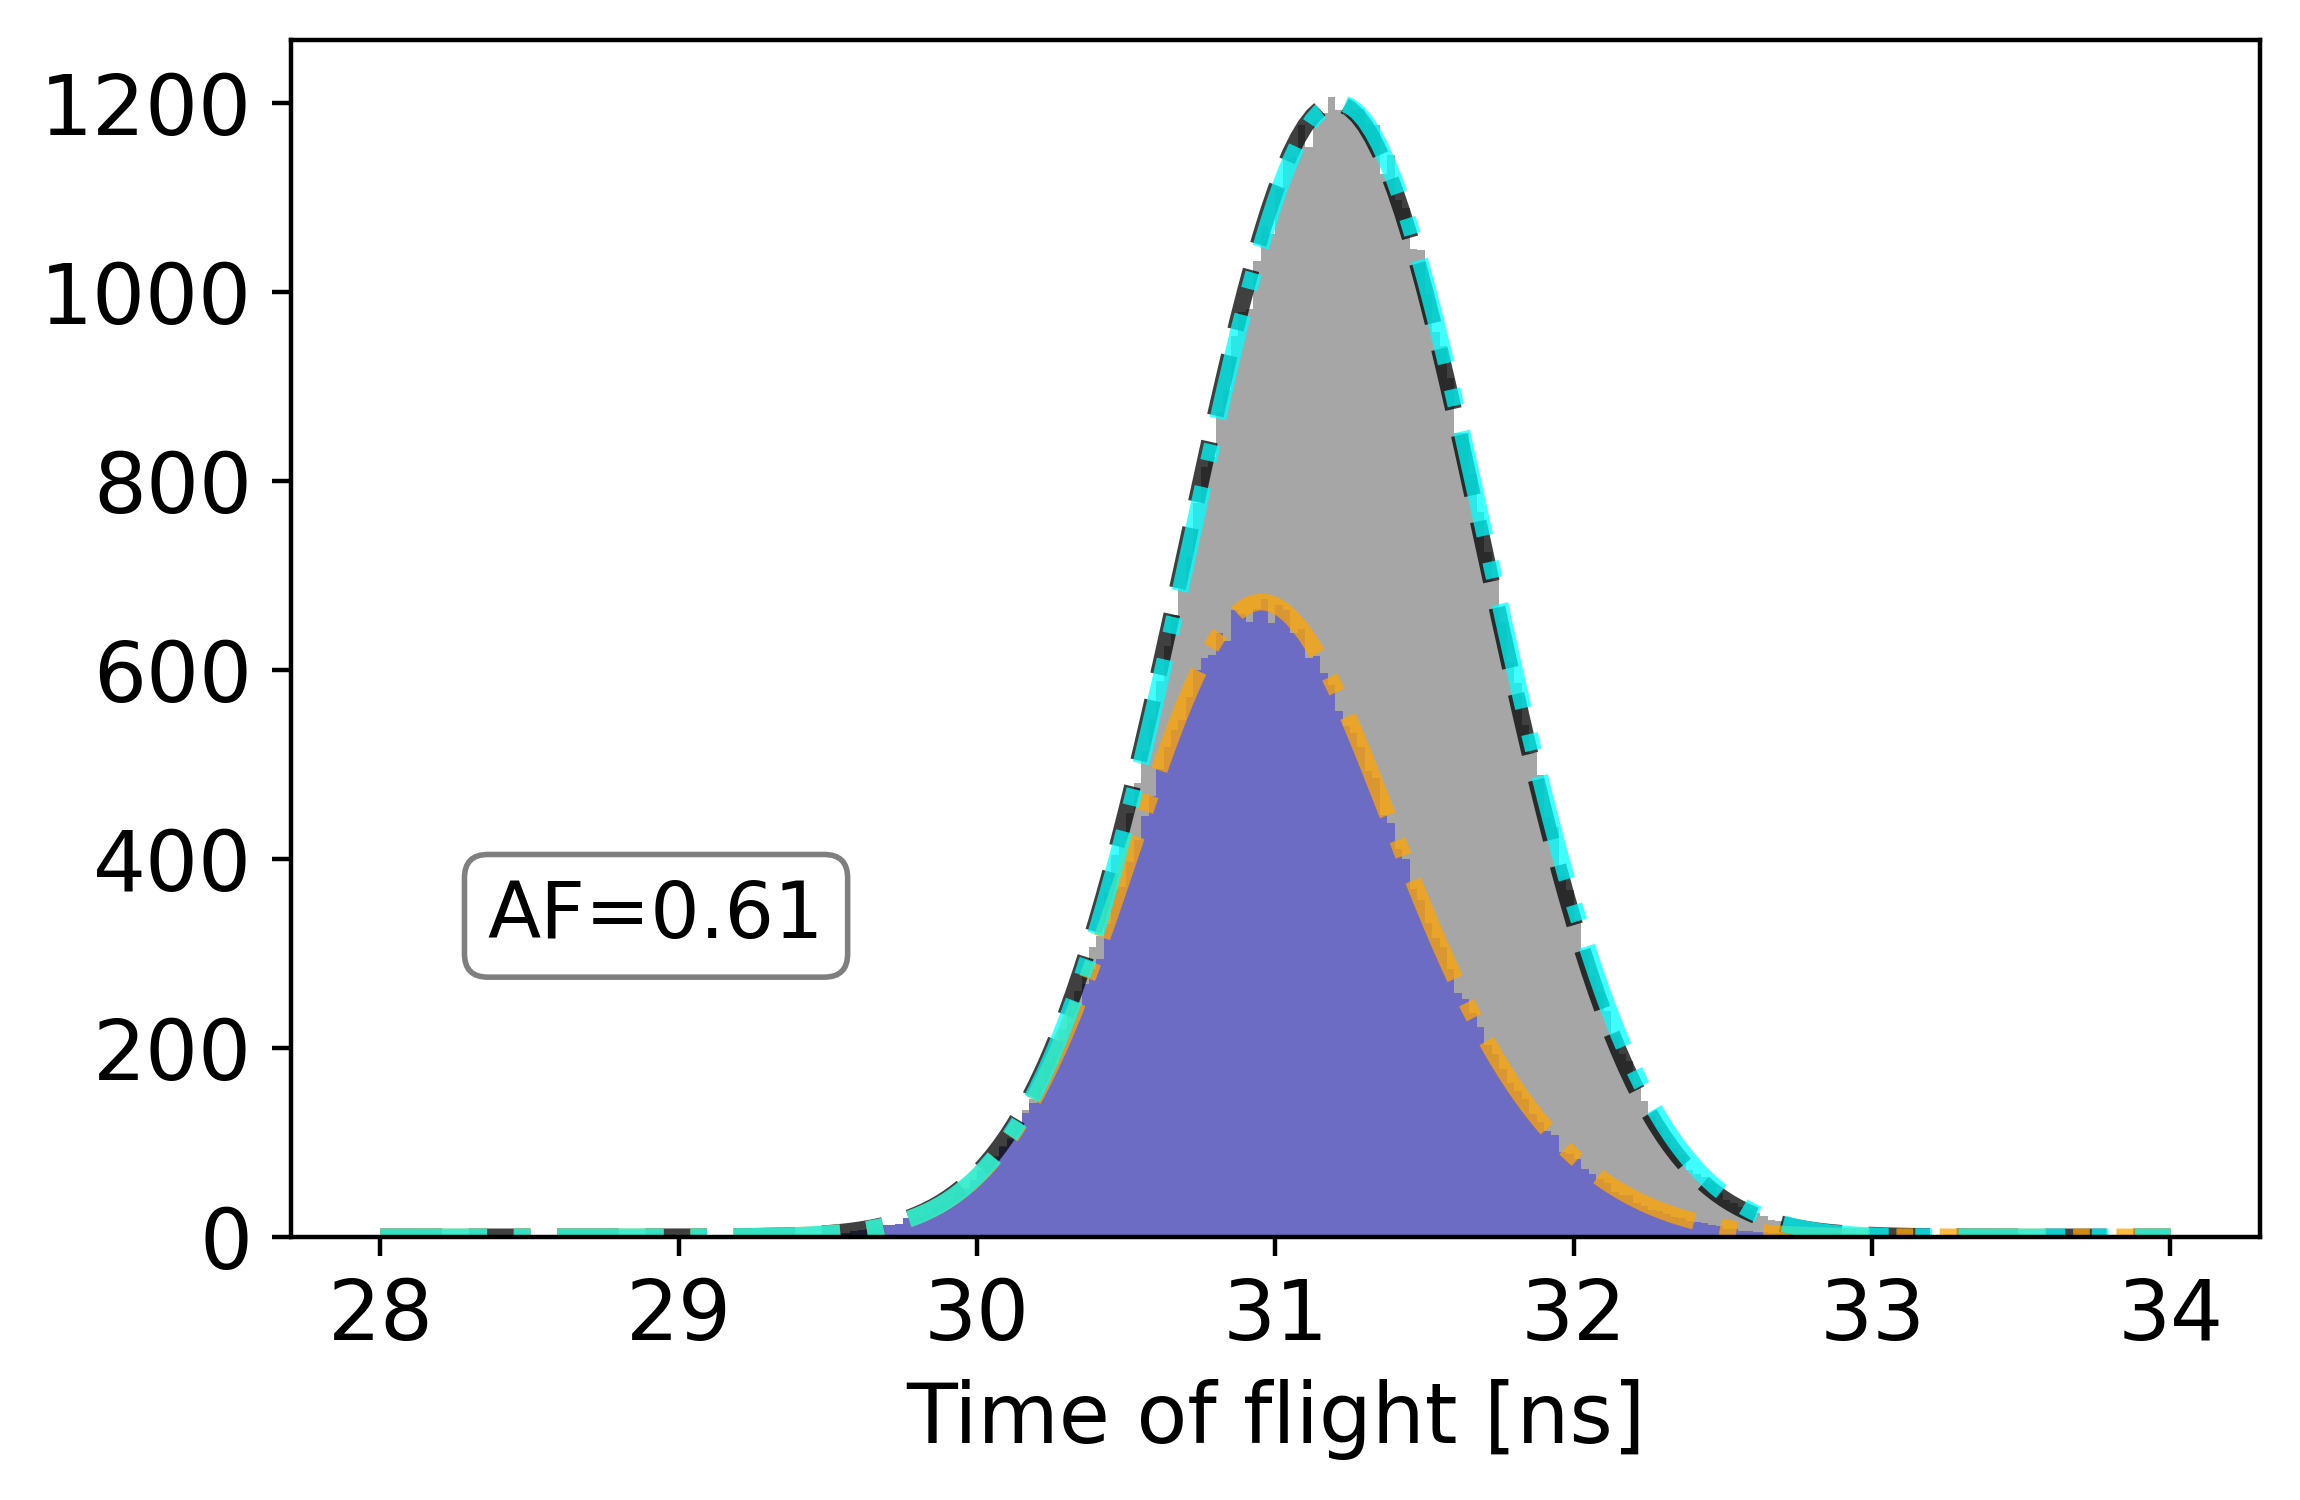

In [53]:
### Histogram of time of flight ###
start = time.time()

fig = plt.figure(dpi=400)
plt.rcParams.update({'font.size': 15})
ax = fig.add_subplot(111)

# Curves
ax.plot(t_fine*1e9, truth/1e6, label='Truth', linestyle='--', alpha=0.75, linewidth=3, color='black')
ax.plot(t_fine*1e9, pois_fit/1e6, label='Poisson Fit', linestyle='-.', alpha=0.75, linewidth=3, color='orange')
ax.plot(t_fine*1e9, dead_fit/1e6, label='Deadtime Fit', linestyle='-.', alpha=0.75, linewidth=3, color='cyan')

# Histograms
bin_array = set_binwidth(t_min, t_max, dt)
n, bins = np.histogram(flight_time, bins=bin_array)
true_n, _ = np.histogram(true_flight_time, bins=bin_array)
print('Histogram plot time elapsed: {:.3} sec'.format(time.time() - start))
binwidth = np.diff(bins)[0]
N = n / binwidth / n_shots
true_N = true_n / binwidth / n_shots
center = 0.5 * (bins[:-1]+bins[1:])
ax.bar(center*1e9, true_N/1e6, align='center', width=binwidth*1e9, color='k', alpha=0.35, label='True Detections')
ax.bar(center*1e9, N/1e6, align='center', width=binwidth*1e9, color='b', alpha=0.35, label='Detections')

# Active Fraction
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.1, 0.3, 'AF={:.2f}'.format(AF), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Styling
ax.set_xlabel('Time of flight [ns]')
# ax.set_ylabel('Arrival rate [MHz]')
# ax.set_yscale('log')
# ax.set_ylim([1e4, 1e10])
plt.tight_layout()
# plt.legend(prop={'size': 11})
plt.tight_layout()
plt.show()
